In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import logging
import numpy as np
import py21cmfast as p21c
import math
import time
import imageio
from py21cmfast import (
    AstroParams,
    CosmoParams,
    FlagOptions,
    UserParams,
    determine_halo_list,
    initial_conditions,
    perturb_field,
    plotting
    )

/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:49: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:33: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
if 0:
    HII_DIM = 128
    BOX_LEN = 128

    start = time.time()

    init_cond = p21c.initial_conditions(
        user_params = {"HII_DIM": HII_DIM, "BOX_LEN": BOX_LEN}, 
        cosmo_params = p21c.CosmoParams(SIGMA_8 = 0.8), 
        random_seed = 42242)

    end = time.time()
    print('Time for init cond: ', end-start, 'sec')

Load in the recovered binarized boxes from Jonathan. Also included are the wedge-filtered coeval boxes, the original coeval boxes from `21cmFAST` (which can be compared to our own generation of these boxes using identical initial conditions to ensure our analysis is correct), and the set of redshifts at which the boxes are generated. 

In [22]:
def load_data_from_h5(filename):

    with h5py.File(filename, "r") as hf:

        print("Datasets: ", list(hf.keys()))

        X = hf["X"][:]
        Y = hf["Ytrue"][:]
        Ypred = hf["Ypred"][:]
        redshifts = hf["redshifts"][:]
        hf.close()
        # Transpose boxes
        X = np.array([x.T for x in X])
        Y = np.array([y.T for y in Y])
        Ypred = np.array([ypred.T for ypred in Ypred])

    return X, Y, Ypred, redshifts

if 1:
    results_file = '/users/jacobkennedy/Desktop/PHYS_459/data/coeval_boxes/z7-8.5_HII-DIM-128_BOX-LEN-128_with_xh_boxes_results.h5'
if 0:
    results_file = '/users/jacobkennedy/Desktop/PHYS_459/data/coeval_boxes/z8.5-10_HII-DIM-128_BOX-LEN-128_with_xh_boxes_results.h5'


'''

X: The wedge-filtered coeval boxes
Y: The original coeval boxes, generated by 21cm Fast, BRIGHTNESS TEMPERATURE
Y_pred: The lightcones that the machine learning model predicts.
redshifts: The redshifts that the coeval boxes were generated at

'''

X, Y, Ypred, redshifts = load_data_from_h5(results_file)


print("X shape: ", X.shape)

Datasets:  ['brightness_temp_boxes', 'ionized_boxes', 'predicted_brightness_temp_boxes', 'redshifts', 'wedge_filtered_brightness_temp_boxes']


KeyError: "Unable to open object (object 'X' doesn't exist)"

In [21]:
print(redshifts)

[8.   8.25 8.5 ]


In [4]:
#Binarize the predicted boxes

def binarize_boxes(boxes, cutoff=0.9):
    num_box = boxes.shape[0]
    for i in range(num_box):
        sup_threshold_inds = (boxes[i] >= cutoff) # map to 1
        sub_threshold_inds = (boxes[i] < cutoff) # map to 0
        boxes[i][sup_threshold_inds] = 1 
        boxes[i][sub_threshold_inds] = 0
    return boxes

In [5]:
binarized_pred_boxes = binarize_boxes(Ypred, cutoff=0.9)

Now initialize an identical coeval box using `21cmFAST` with the same initial conditions, which will carry all the additional information on halo positions and sizes which we can use to analyze the recovered boxes.

In [6]:
# Init cond for .h5 file
if 0:
    HII_DIM = 128
    BOX_LEN = 128

    start = time.time()

    init_cond = p21c.initial_conditions(
        user_params = {"HII_DIM": HII_DIM, "BOX_LEN": BOX_LEN}, 
        cosmo_params = p21c.CosmoParams(SIGMA_8 = 0.8), 
        random_seed = 42242)

    end = time.time()
    print('Time for init cond: ', end-start, 'sec')

In [7]:
# Now perturb to desired redshift and get halo masses
if 0:
    num_z = len(redshifts)
    ionized_boxes_z = np.zeros((num_z,128,128,128))
    halo_coords_z = []
    halo_masses_z = []
    #hf_ionbox_z = h5py.File('ionized_boxes_8.5-10.h5', 'a')
    #hf_halos_z = h5py.File('halo_masses_coords_8.5-10.h5', 'a')

    for i in range(num_z):
        start = time.time()
        pt_box = perturb_field(
            redshift=redshifts[i],
            init_boxes=init_cond,
            #user_params=user_params,
            #cosmo_params=cosmo_params,
            )
        end = time.time()
        print('Perturbed box time taken: ', end-start, 'sec')

        start = time.time()
        ionized=p21c.ionize_box(perturbed_field = pt_box)
        ionized_boxes_z[i] = ionized.xH_box
        #hf_ionbox_z.create_dataset('ionized_box_'+repr(redshifts[i]), data=ionized.xH_box)

        end = time.time()
        print('Ionized Box time', end-start, 'sec')

        start = time.time()
        halos = determine_halo_list(
            redshift=redshifts[i],
            init_boxes=init_cond,
            #user_params=user_params, 
            #cosmo_params=cosmo_params,
            #astro_params=astro_params,
            #flag_options=flag_options,
            regenerate=True,
            write=False,
            OPTIMIZE=False,
            )
        end = time.time()
        print('Got halo list in ', end-start, 'sec')

        list_halo_coords = halos.halo_coords
        halo_coords_z.append(list_halo_coords)
        list_halo_masses = halos.halo_masses
        halo_masses_z.append(list_halo_masses)
        #hf_halos_z.create_dataset('halo_masses_'+repr(redshifts[i]), data=list_halo_masses)
        #hf_halos_z.create_dataset('halo_coords_'+repr(redshifts[i]), data=list_halo_coords)

    #hf_ionbox_z.close()
    #hf_halos_z.close()

    halo_coords_z = np.array(halo_coords_z)
    halo_masses_z = np.array(halo_masses_z)

Ionize the coeval box and plot its brightness temperature as a check (we have already perturbed the box to redshift 8). Plotting a slice of the box requires one to specify an axis and index at which the slice is made, in this instance we have chosen the axis to be $x$ (0), and the index to be 0. The boxes are constructed in such a way that the $x$-dimension is the depth of the box along the line of sight and the $z$ axis is the height of the box (therefore $y$ is just the transverse width of the box). 

In [8]:
# This will be at z=10 as the last ionized box was for z=10
if 0:
    ionized=p21c.ionize_box(perturbed_field = pt_box)
    brightness_temp=p21c.brightness_temperature(ionized_box=ionized, perturbed_field=pt_box)
    p21c.plotting.coeval_sliceplot(brightness_temp, slice_index=0, slice_axis=0);

Now we can examine what types of halo masses `21cmFAST` generates. This is done using the list of halo-type objects `halos`, which we have already obtained above. These objects contain attributes pertaining to the halo mass and coordinates in the box. Looking at the distribution of halo masses (via a histogram) is useful to understand the range and frequency of halo masses in the box.

In [8]:
# Define function to plot log of halo masses

def plot_histogram(halomasses, name, save=False, ax=None, fig=None, label='', colour='red', bins=None,lims=None):
    if (ax is None) and (fig is None):
        fig,ax = plt.subplots(figsize=(14,8))
        colour='blue'
    log_halomasses = np.log10(halomasses)
    if bins == None:
        bins=len(np.unique(log_halomasses))
    ax.hist(log_halomasses,bins=bins, lw=1, ec='black', fc=colour, alpha=0.5, label=label,range=lims) # normalize histogram
    ax.set_yscale('log')
    ax.set_xlabel('$log(M_{halo} / M_{Sun})$', fontsize = 20)
    ax.set_title('Halo Mass Distribution Over '+name, fontsize = 20)
    ax.set_ylabel('Halo Counts', fontsize = 20);
    ax.tick_params(axis='x',labelsize=20)
    ax.tick_params(axis='y',labelsize=20)
    ax.legend(fontsize=16)
    if save:
        splitname = name.split()
        savename = "_".join(splitname)
        fig1.savefig('halo_mass_distr_'+savename)
    return fig, ax

In [9]:
# Plot histogram of halo masses from whole cube
if 0:
    halo_masses_cube = halos.halo_masses
    hist_fig, hist_ax = plot_histogram(halo_masses_cube,'Whole Box',save=False,label='All Regions')

To access the halos in a particular slice, we can specify the particular index we want to keep. As mentioned above, the coordinates of the box take the form $(z,y,x)$. This is done below for an $x$-axis slice with index $x=0$. The corresponding halo mass histogram is displayed below as well, and has a similar general shape to that which includes the halo masses from the whole box.

In [10]:
if 0:
    halo_masses_slice = halos.halo_masses[halos.halo_coords[:,2]==0]

    hist_slice_fig, hist_slice_ax = plot_histogram(halo_masses_slice, 'x=0 Slice', save=False)

If we wish to get a sorted list of halo masses and halo coordinates (in the same order), this can be done using the following function.

In [11]:
def sort_masses(halomasses, halocoords):
    sorted_halomasses_inds = np.argsort(halomasses)
    sorted_halomasses = halomasses[sorted_halomasses_inds]
    sorted_halocoords = halocoords[sorted_halomasses_inds]
    return [sorted_halomasses,sorted_halocoords]

Given we want to examine what halo masses are found in the recovered boxes, we need to write a function to find the halo coordinates and masses corresponding to those halos found in the ionized bubbles (and neutral areas as well).

In [12]:
def get_n_i_mass_coords(halocoords, halomasses, ionizedbox, n_frac_threshold=0.9):
    '''
    halocoords: 
            Coordinates of halos in box.
    halomasses:
            Masses of halos in box
    ionizedbox: 
            3-D box of HII_DIM sidelength, with entries indicating neutral fraction of voxel. 
    n_frac_threshold:
            Neutral fraction threshold, default is 0.9.
    ''' 
    halo_low_res_coords = halocoords // 3 # need to scale down dimension from high to low resolution
    
    neutral_halo_coords = []
    neutral_halo_masses = []
    ionized_halo_coords = []
    ionized_halo_masses = []
    
    for i in range(len(halo_low_res_coords)): 
        z = halo_low_res_coords[i][0]
        y = halo_low_res_coords[i][1]
        x = halo_low_res_coords[i][2]
        
        if ionizedbox[z,y,x] >=n_frac_threshold: # check if neutral fraction greater than threshold
            neutral_halo_coords.append(np.array([z,y,x]))
            neutral_halo_masses += [halomasses[i]]
            
        else:
            ionized_halo_coords.append(np.array([z,y,x]))
            ionized_halo_masses += [halomasses[i]]

    
    #return [neutral_halo_coords, neutral_halo_masses, ionized_halo_coords, ionized_halo_masses]
    return np.array(neutral_halo_coords),np.array(neutral_halo_masses), np.array(ionized_halo_coords), np.array(ionized_halo_masses)

In [13]:
# function to read in masses, coords, ionized boxes

def load_halo_ion_from_h5(ion_box_file,halo_file,redshifts):
    
    num_z = len(redshifts)
    ion_boxes_z = np.zeros((num_z,128,128,128))
    halo_coord_z = []
    halo_mass_z = []
    
    with h5py.File(ion_box_file, "r") as hf:
        #print("Datasets: ", list(hf.keys()))
        for i in range(num_z):
            ion_box_z_name = 'ionized_box_'+repr(redshifts[i])
            #print(ion_box_z_name)
            ion_boxes_z[i] = hf[ion_box_z_name][:]
        hf.close()
    
    with h5py.File(halo_file, "r") as hf1:
        #print("Datasets: ", list(hf1.keys()))
        for i in range(num_z):
            temp_halo_mass_name = 'halo_masses_'+repr(redshifts[i])
            temp_halo_coord_name = 'halo_coords_'+repr(redshifts[i])
            #print(temp_halo_mass_name)
            #print(temp_halo_coord_name)
            temp_halo_masses = hf1[temp_halo_mass_name][:]
            temp_halo_coords = hf1[temp_halo_coord_name][:]
            halo_coord_z.append(temp_halo_coords)
            halo_mass_z.append(temp_halo_masses)
        hf1.close()

    return ion_boxes_z, np.array(halo_coord_z), np.array(halo_mass_z)

In [14]:
ion_file = 'ionized_boxes_8.5-10.h5'
halos_file = 'halo_masses_coords_8.5-10.h5'

ionized_boxes_z, halo_coords_z, halo_masses_z = load_halo_ion_from_h5(ion_file,halos_file,redshifts)

/var/folders/xs/9jq8mv4s1clbtpmn6f0vrgsc0000gp/T/ipykernel_31590/280471522.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ion_boxes_z, np.array(halo_coord_z), np.array(halo_mass_z)


In [15]:
binarized_gt_boxes_z = binarize_boxes(ionized_boxes_z) # binarize the boxes for plotting, etc

In [16]:
if 0:
    for i in range(num_z):
        fig3, ax3 = plt.subplots(ncols=2,figsize=[14, 8])
        n_x=50
        #halo_slice_coords = i_rec_halo_coords[i_rec_halo_coords[:,0]==n_x]
        ax3[0].imshow(binarized_gt_boxes[i][n_x,:,:], cmap='Greys', origin='lower') # take x = 0 slice
        print('GT Slice Neutral Fraction: ', binarized_gt_boxes[i][n_x,:,:].mean())
        ax3[1].imshow(Y[i][n_x,:,:], cmap='Greys', origin='lower') # take x = 0 slice
        print('Pred Slice Neutral Fraction: ', binarized_pred_boxes[i][n_x,:,:].mean())
        #im = ax3.scatter(x=halo_coords_z[:,1, y=nslice_halo_coords[:,0], 
        #            marker='*', s=5.0, label = 'Neutral Region Halos', c='r')
        #im2 = ax3.scatter(x=islice_halo_coords[:,1], y=islice_halo_coords[:,0], 
        #            marker='*', s=5.0, label = 'Ionized Region Halos', c='blue')
        ax3[0].set_xlim(0, 127)
        ax3[0].set_ylim(0, 127)
        ax3[1].set_xlim(0, 127)
        ax3[1].set_ylim(0, 127)
        #ax3.legend(fontsize=14, loc='right')
        ax3[0].set_ylabel('z-axis [Mpc]', fontsize=20)
        ax3[0].set_xlabel('y-axis [Mpc]', fontsize=20)
        ax3[1].set_ylabel('z-axis [Mpc]', fontsize=20)
        ax3[1].set_xlabel('y-axis [Mpc]', fontsize=20)
        ax3[0].set_title(r'Binarized GT Slice z = '+repr(redshifts[i])+r', $\bar{x}_{HI} = $'+repr(np.round(binarized_gt_boxes[i][n_x,:,:].mean(),3)), fontsize=20)
        ax3[1].set_title(r'Binarized Pred Slice z = '+repr(redshifts[i])+r', $\bar{x}_{HI} = $'+repr(np.round(binarized_pred_boxes[i][n_x,:,:].mean(),3)), fontsize=20)
        #ax3.set_title('Recovered (Binarized) Map for Slice $x = 0$, z ='+ repr(redshifts[i]), fontsize=20);
        #fig3.savefig('/Users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/110821/'+'slice_comp_z'+repr(redshifts[i])+'.png')

In [18]:
'''
def get_missed_halos(halo_coords, halo_masses, gt_ionized_box, pred_ionized_box):
    # First we need to get list of halo masses
    gt_neut_h_coords, gt_neut_h_masses, gt_ion_h_coords, gt_ion_h_masses = get_n_i_mass_coords(halo_coords, halo_masses, gt_ionized_box)
    pred_neut_h_coords, pred_neut_h_masses, pred_ion_h_coords, pred_ion_h_masses = get_n_i_mass_coords(halo_coords, halo_masses, pred_ionized_box)
    sorted_gt_ion_h_masses, sorted_gt_ion_h_coords = sort_masses(gt_ion_h_masses, gt_ion_h_coords)    
    sorted_pred_ion_h_masses, sorted_pred_ion_h_coords = sort_masses(pred_ion_h_masses, pred_ion_h_coords)
    # get number of unique halo masses
    n_unique_gt_ion_h_masses = np.unique(sorted_gt_ion_h_masses)
    ion_h_coords_common = []
    ion_h_masses_common = []
    ion_h_coords_gt_not_pred = []
    ion_h_masses_gt_not_pred = []
    ion_h_coords_pred_not_gt = []
    ion_h_masses_pred_not_gt = []
    for i in range(len(sorted_gt_ion_h_masses)):  
'''    

'\ndef get_missed_halos(halo_coords, halo_masses, gt_ionized_box, pred_ionized_box):\n    # First we need to get list of halo masses\n    gt_neut_h_coords, gt_neut_h_masses, gt_ion_h_coords, gt_ion_h_masses = get_n_i_mass_coords(halo_coords, halo_masses, gt_ionized_box)\n    pred_neut_h_coords, pred_neut_h_masses, pred_ion_h_coords, pred_ion_h_masses = get_n_i_mass_coords(halo_coords, halo_masses, pred_ionized_box)\n    sorted_gt_ion_h_masses, sorted_gt_ion_h_coords = sort_masses(gt_ion_h_masses, gt_ion_h_coords)    \n    sorted_pred_ion_h_masses, sorted_pred_ion_h_coords = sort_masses(pred_ion_h_masses, pred_ion_h_coords)\n    # get number of unique halo masses\n    n_unique_gt_ion_h_masses = np.unique(sorted_gt_ion_h_masses)\n    ion_h_coords_common = []\n    ion_h_masses_common = []\n    ion_h_coords_gt_not_pred = []\n    ion_h_masses_gt_not_pred = []\n    ion_h_coords_pred_not_gt = []\n    ion_h_masses_pred_not_gt = []\n    for i in range(len(sorted_gt_ion_h_masses)):  \n'

In [19]:
n_rec_halo_coords, n_rec_halo_masses, i_rec_halo_coords, i_rec_halo_masses = get_n_i_mass_coords(halo_coords_z[0], halo_masses_z[0],binarized_pred_boxes[0]) 
n_gt_halo_coords, n_gt_halo_masses, i_gt_halo_coords, i_gt_halo_masses = get_n_i_mass_coords(halo_coords_z[0], halo_masses_z[0], binarized_gt_boxes_z[0])  

In [63]:
sorted_i_rec_halo_coords=i_rec_halo_coords[np.argsort(i_rec_halo_coords[:,0], axis=0)]
sorted_i_gt_halo_coords=i_gt_halo_coords[np.argsort(i_gt_halo_coords[:,0], axis=0)]
print(np.intersect1d(sorted_i_rec_halo_coords,sorted_i_gt_halo_coords, return_indices=True))# if sorted, we can immediately disregard those in 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], dtype=int32), array([     0,    157,     58,      4,     70,     73,    283,    427,
          334,    307,    286,    394,    388,    638,    376,    355,
          368,    359,   1924,   1703,   1723,   1705,   1696,   2401,
        46162,  46171,  36700,   1802,   1753,   1759,   1787

All arrays are organized according to increasing redshift.

We can now use this function to find the halo masses in the ionized and neutral regions of the recovered binarized box from Sam's code. At the same time, we can apply the same function to the ground truth map to see what halo (masses) are in those bubbles as well.

Recovered box retrieval took:  17.26330804824829
Ground truth box retrieval took:  16.996783018112183
All halo masses in ground truth ionized regions are also in predicted ionized regions:  True
Redshift:  8.5 , with GT ionized fraction:  0.7358479499816895
Num missed ionized masses:  1098314
Num incorrectly included ionized masses:  0 

Plotting took:  0.05449223518371582
Recovered box retrieval took:  17.019740104675293
Ground truth box retrieval took:  15.302470922470093
All halo masses in ground truth ionized regions are also in predicted ionized regions:  True
Redshift:  8.75 , with GT ionized fraction:  0.7717900276184082
Num missed ionized masses:  986808
Num incorrectly included ionized masses:  -542 

Plotting took:  0.03716731071472168
Recovered box retrieval took:  14.729878902435303
Ground truth box retrieval took:  14.415694952011108
All halo masses in ground truth ionized regions are also in predicted ionized regions:  True
Redshift:  9.0 , with GT ionized fraction:  0.80

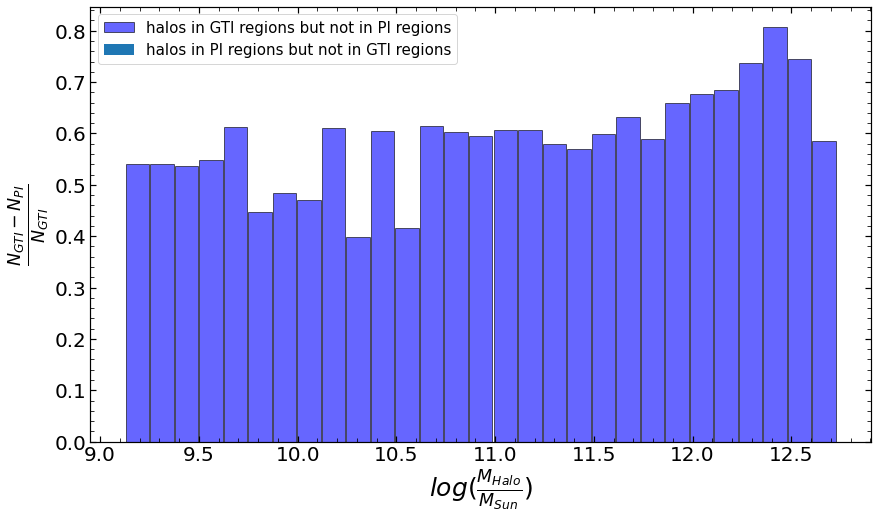

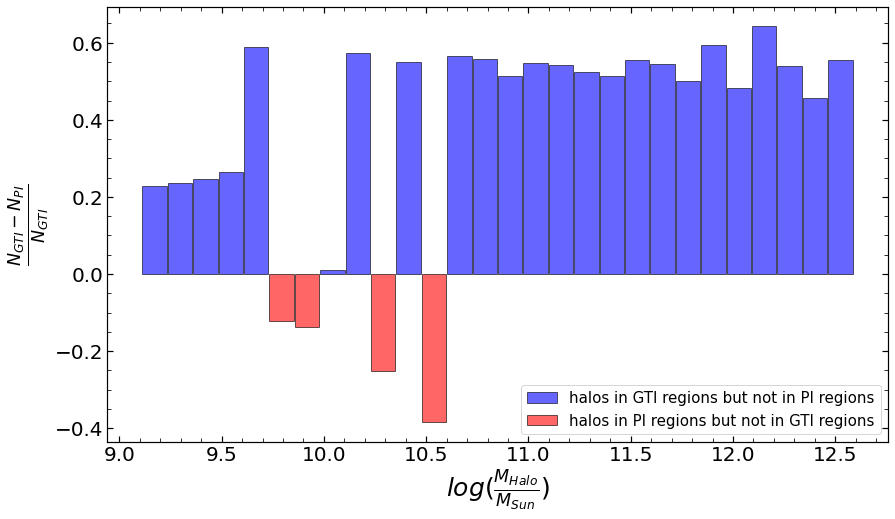

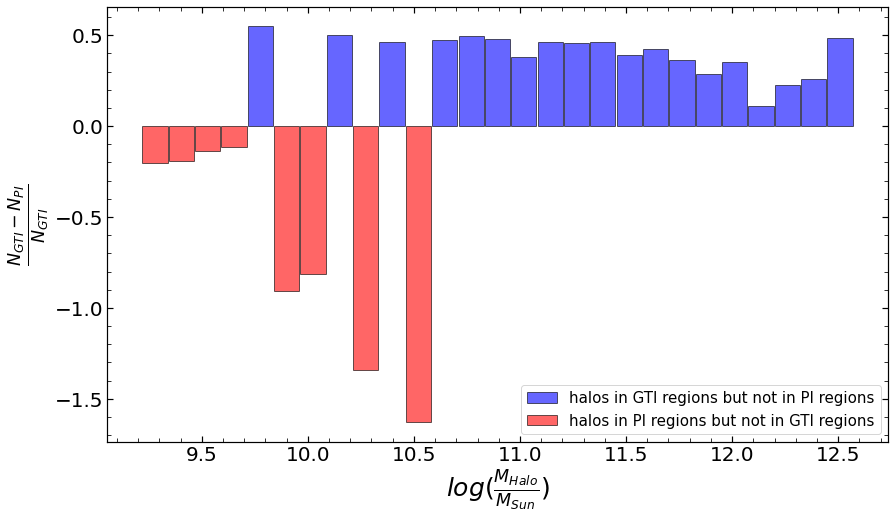

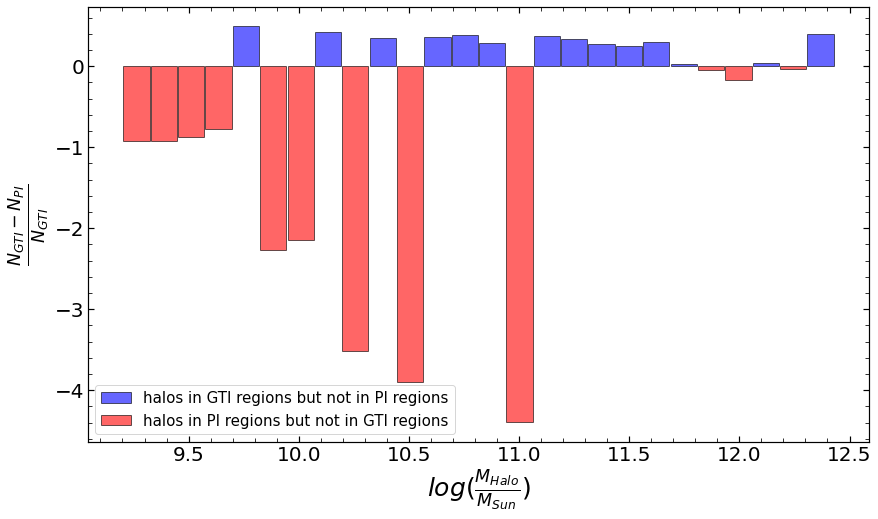

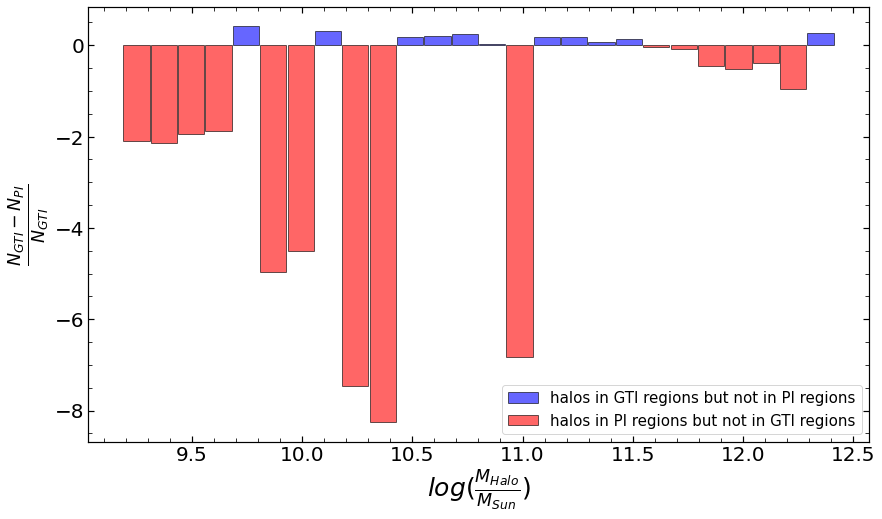

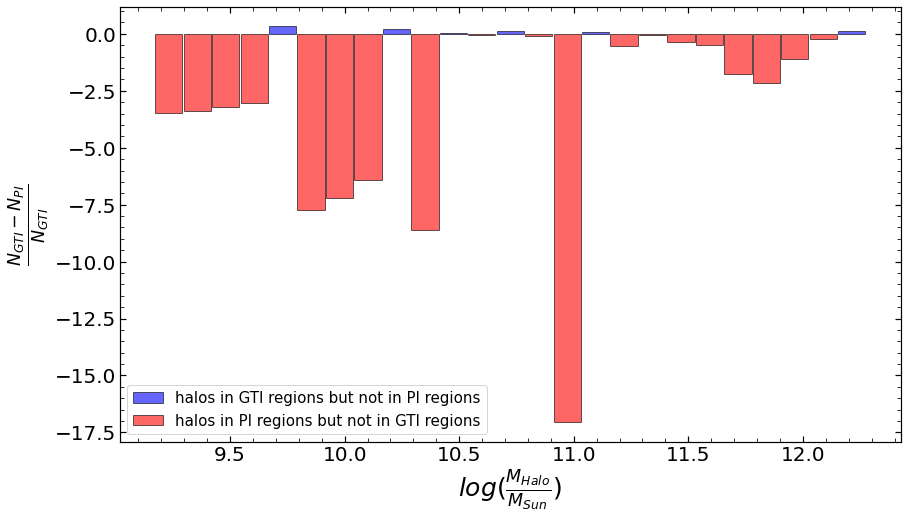

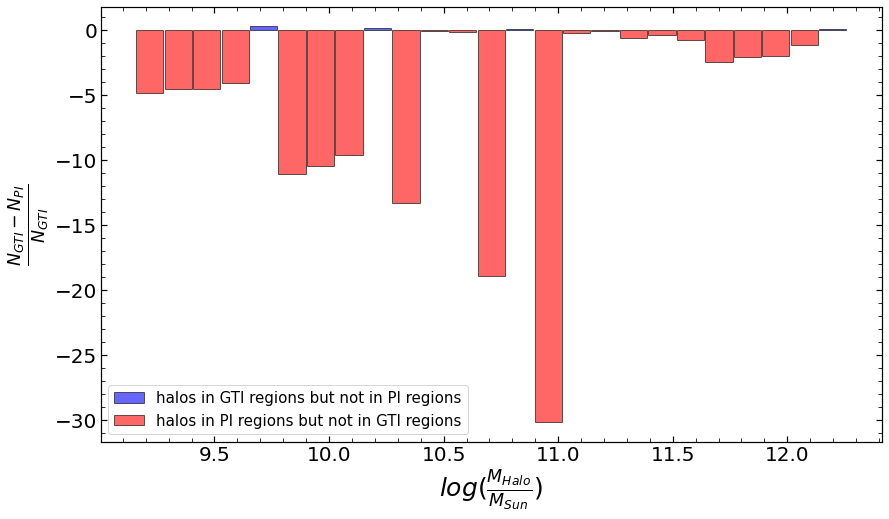

In [30]:
num_z = len(redshifts)
plot = True

all_n_rec_halo_coords=[]
all_n_rec_halo_masses=[]
all_i_rec_halo_coords=[]
all_i_rec_halo_masses=[]
all_n_gt_halo_coords=[]
all_n_gt_halo_masses=[]
all_i_gt_halo_coords=[]
all_i_gt_halo_masses=[]


for i in range(num_z):

    # recovered box
    rec_ionized_box = binarized_pred_boxes[i]
    start=time.time()
    n_rec_halo_coords, n_rec_halo_masses, i_rec_halo_coords, i_rec_halo_masses = get_n_i_mass_coords(halo_coords_z[i], halo_masses_z[i], rec_ionized_box)    
    all_n_rec_halo_coords.append(n_rec_halo_coords)
    all_n_rec_halo_masses.append(n_rec_halo_masses)
    all_i_rec_halo_coords.append(i_rec_halo_coords)
    all_i_rec_halo_masses.append(i_rec_halo_masses)
    end=time.time()
    print('Recovered box retrieval took: ', end-start)
    # ground truth box
    start=time.time()
    gt_ionized_box = binarized_gt_boxes_z[i]
    n_gt_halo_coords, n_gt_halo_masses, i_gt_halo_coords, i_gt_halo_masses = get_n_i_mass_coords(halo_coords_z[i], halo_masses_z[i], gt_ionized_box)  
    all_n_gt_halo_coords.append(n_gt_halo_coords)
    all_n_gt_halo_masses.append(n_gt_halo_masses)
    all_i_gt_halo_coords.append(i_gt_halo_coords)
    all_i_gt_halo_masses.append(i_gt_halo_masses)
    end=time.time()
    print('Ground truth box retrieval took: ', end-start)
    
    # now find unique masses
    uniq_i_gt_masses, uniq_i_gt_mass_counts = np.unique(i_gt_halo_masses, return_counts=True)
    uniq_i_rec_masses, uniq_i_rec_mass_counts = np.unique(i_rec_halo_masses, return_counts=True)

    # double check all masses in one are in the other
    common_masses = np.intersect1d(uniq_i_gt_masses,uniq_i_rec_masses)
    print('All halo masses in ground truth ionized regions are also in predicted ionized regions: ',
      ((len(common_masses)==len(uniq_i_rec_masses)) and (len(common_masses)==len(uniq_i_gt_masses)))) 

    common_mass_counts =  uniq_i_gt_mass_counts - uniq_i_rec_mass_counts
    
    if plot:
        start=time.time()
        fig,ax=plt.subplots(figsize=[14,8])

        fracs = common_mass_counts / uniq_i_gt_mass_counts
        i_rec_missed_inds_frac = np.argwhere(fracs > 0)[:,0]
        i_rec_incorr_inds_frac = np.argwhere(fracs < 0)[:,0]
        i_rec_missed_fracs = np.array(fracs[i_rec_missed_inds_frac])
        i_rec_missed_masses = np.array(common_masses[i_rec_missed_inds_frac])
        i_rec_incorr_fracs = np.array(fracs[i_rec_incorr_inds_frac])
        i_rec_incorr_masses = np.array(common_masses[i_rec_incorr_inds_frac])
        print('Redshift: ', repr(redshifts[i]), ', with GT ionized fraction: ', np.mean(gt_ionized_box))
        print('Num missed ionized masses: ', np.sum(common_mass_counts[i_rec_missed_inds_frac]))
        print('Num incorrectly included ionized masses: ', np.sum(common_mass_counts[i_rec_incorr_inds_frac]), '\n')
        ax.bar(np.log10(i_rec_missed_masses), i_rec_missed_fracs, width=0.119,alpha=0.6,
                edgecolor='black', linewidth=1,color='blue', label='halos in GTI regions but not in PI regions')
        ax.bar(np.log10(i_rec_incorr_masses), i_rec_incorr_fracs, width=0.119,alpha=0.6,
                edgecolor='black', linewidth=1, color='red', label='halos in PI regions but not in GTI regions')
        ax.set_ylabel(r'$\frac{N_{GTI} - N_{PI}}{N_{GTI}}$', fontsize=25)
        ax.set_xlabel(r'$log(\frac{M_{Halo}}{M_{Sun}})$', fontsize=25)
        ax.tick_params(axis='x',labelsize=20)
        ax.tick_params(axis='y',labelsize=20)
        ax.legend(fontsize=15)
        #fig.savefig('/users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/110821/bar_graph_mischaracterized_halos_z'+repr(redshifts[i])+'.jpeg');
        end=time.time()
    print('Plotting took: ', end-start)

We can check that our results makes sense by plotting the ionization maps for a given slice and seeing the overlap of the GTI and PI regions.

GT Slice Neutral Fraction:  0.79071044921875
Pred Slice Neutral Fraction:  0.95513916015625
GT Slice Neutral Fraction:  0.81671142578125
Pred Slice Neutral Fraction:  0.93572998046875
GT Slice Neutral Fraction:  0.83978271484375
Pred Slice Neutral Fraction:  0.92132568359375
GT Slice Neutral Fraction:  0.86029052734375
Pred Slice Neutral Fraction:  0.89398193359375
GT Slice Neutral Fraction:  0.87823486328125
Pred Slice Neutral Fraction:  0.9010009765625
GT Slice Neutral Fraction:  0.8927001953125
Pred Slice Neutral Fraction:  0.84417724609375
GT Slice Neutral Fraction:  0.90704345703125
Pred Slice Neutral Fraction:  0.87286376953125


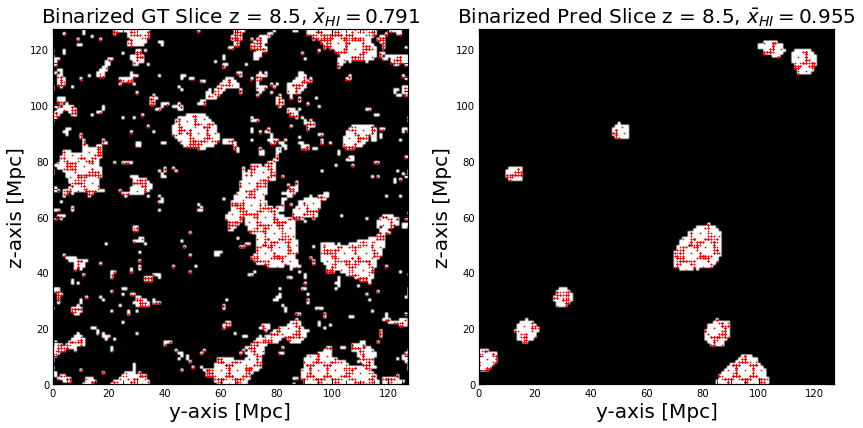

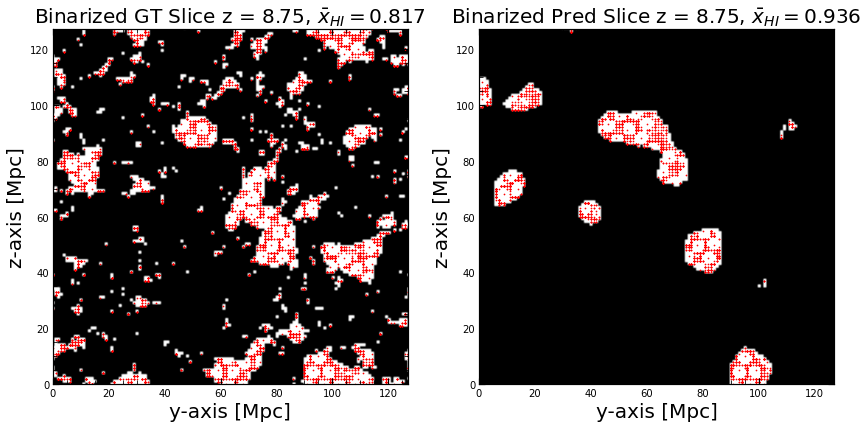

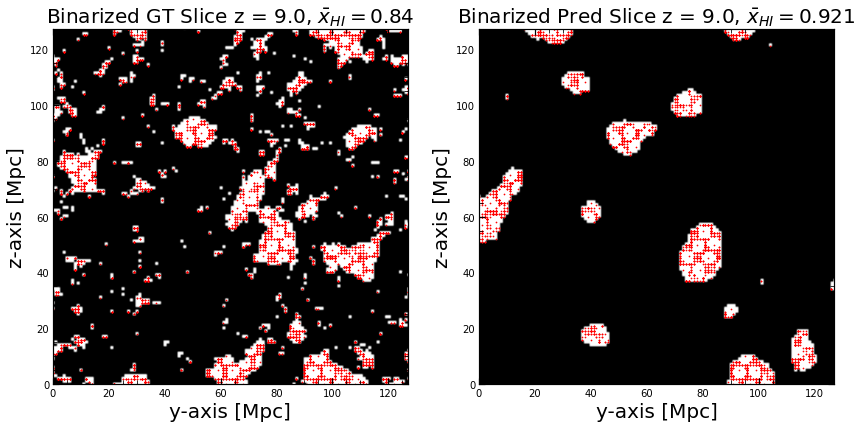

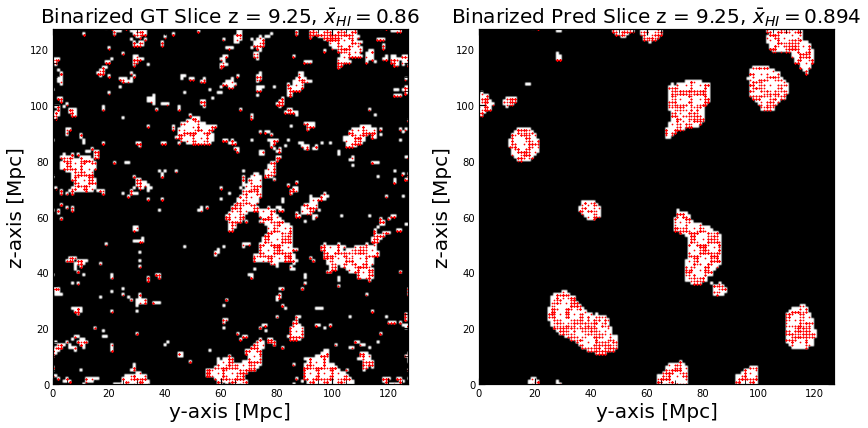

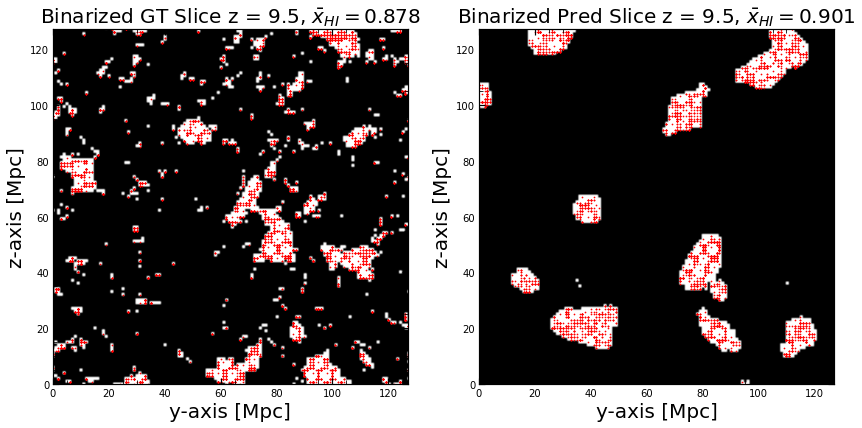

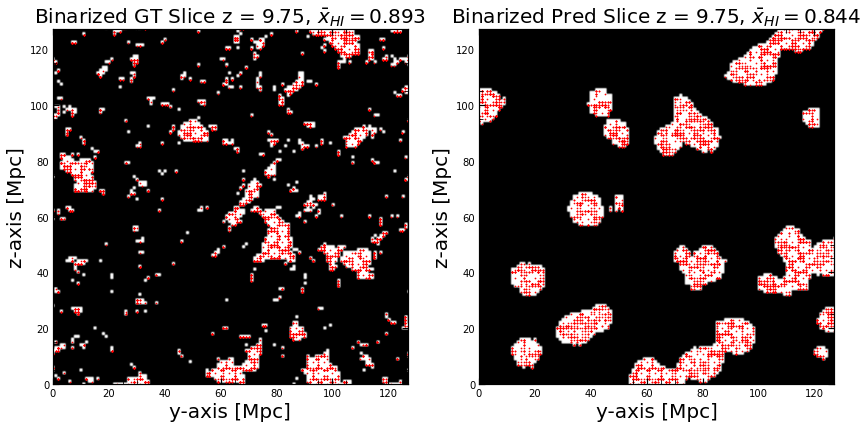

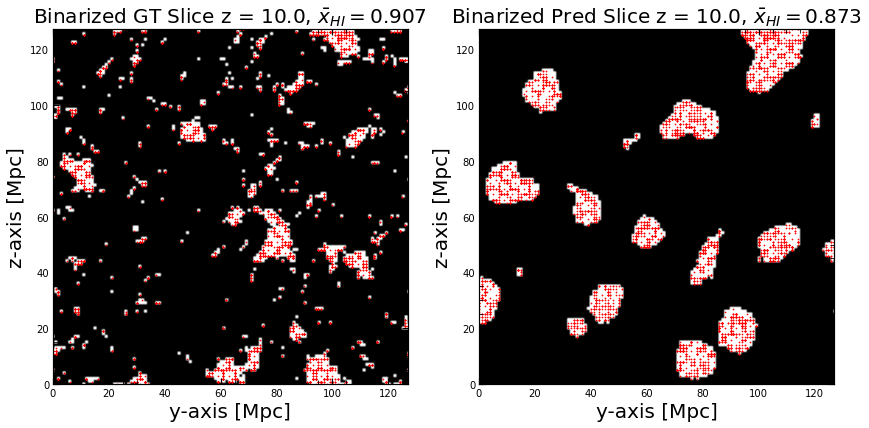

In [19]:
for i in range(num_z):
    fig3, ax3 = plt.subplots(ncols=2,figsize=[14, 8])
    n_x=0
    i_rec_halo_slice_coords = all_i_rec_halo_coords[i][all_i_rec_halo_coords[i][:,0]==n_x]
    i_gt_halo_slice_coords = all_i_gt_halo_coords[i][all_i_gt_halo_coords[i][:,0]==n_x]
    ax3[0].imshow(binarized_gt_boxes_z[i][n_x,:,:], cmap='Greys', origin='lower') # take x = 0 slice
    print('GT Slice Neutral Fraction: ', binarized_gt_boxes_z[i][n_x,:,:].mean())
    ax3[1].imshow(binarized_pred_boxes[i][n_x,:,:], cmap='Greys', origin='lower') # take x = 0 slice
    print('Pred Slice Neutral Fraction: ', binarized_pred_boxes[i][n_x,:,:].mean())
    im = ax3[1].scatter(x=i_rec_halo_slice_coords[:,2], y=i_rec_halo_slice_coords[:,1], 
                marker='.', s=2.0, label = 'Ionized Pred Region Halos', c='r')
    im = ax3[0].scatter(x=i_gt_halo_slice_coords[:,2], y=i_gt_halo_slice_coords[:,1], 
                marker='.', s=2.0, label = 'Ionized GT Region Halos', c='r')
    ax3[0].set_xlim(0, 127)
    ax3[0].set_ylim(0, 127)
    ax3[1].set_xlim(0, 127)
    ax3[1].set_ylim(0, 127)
    #ax3.legend(fontsize=14, loc='right')
    ax3[0].set_ylabel('z-axis [Mpc]', fontsize=20)
    ax3[0].set_xlabel('y-axis [Mpc]', fontsize=20)
    ax3[1].set_ylabel('z-axis [Mpc]', fontsize=20)
    ax3[1].set_xlabel('y-axis [Mpc]', fontsize=20)
    ax3[0].set_title(r'Binarized GT Slice z = '+repr(redshifts[i])+r', $\bar{x}_{HI} = $'+repr(np.round(binarized_gt_boxes_z[i][n_x,:,:].mean(),3)), fontsize=20)
    ax3[1].set_title(r'Binarized Pred Slice z = '+repr(redshifts[i])+r', $\bar{x}_{HI} = $'+repr(np.round(binarized_pred_boxes[i][n_x,:,:].mean(),3)), fontsize=20)
    #ax3.set_title('Recovered (Binarized) Map for Slice $x = 0$, z ='+ repr(redshifts[i]), fontsize=20);
    #fig3.savefig('/Users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/110821/'+'slice_comp_z_i_halos_'+repr(redshifts[i])+'.jpeg')

In [31]:
print(redshifts)

[ 8.5   8.75  9.    9.25  9.5   9.75 10.  ]


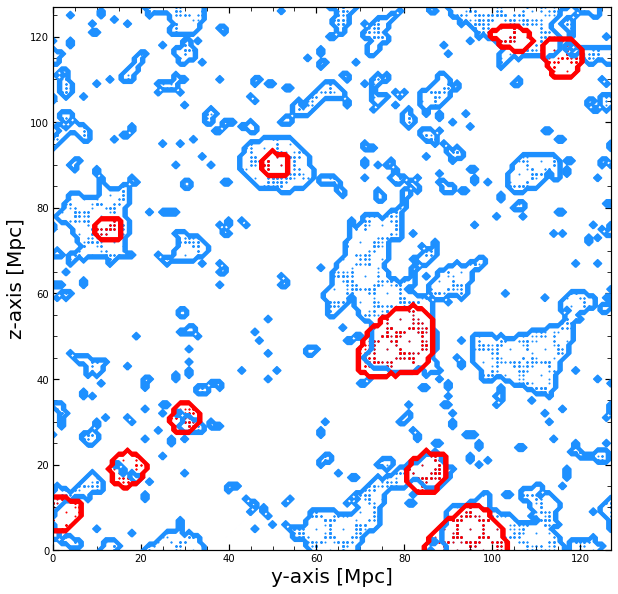

In [40]:
x = np.arange(0,128)
y = np.arange(0,128)
X,Y = np.meshgrid(x,y)
n_x = 0
for i in range(1):
    i_rec_halo_slice_coords = all_i_rec_halo_coords[0][all_i_rec_halo_coords[0][:,0]==n_x]
    i_gt_halo_slice_coords = all_i_gt_halo_coords[0][all_i_gt_halo_coords[0][:,0]==n_x]
    gt_slice = binarized_gt_boxes_z[0][i,:,:]
    pred_slice = binarized_pred_boxes[0][i,:,:]
    fig10,ax10 = plt.subplots(figsize=[10,10])
    ax10.scatter(x=i_gt_halo_slice_coords[:,2], y=i_gt_halo_slice_coords[:,1], 
                marker='.', s=4.0, c='dodgerblue')
    ax10.scatter(x=i_rec_halo_slice_coords[:,2], y=i_rec_halo_slice_coords[:,1], 
                marker='.', s=4.0,  c='red')
    ax10.contour(X,Y,gt_slice, colors='dodgerblue')
    ax10.contour(X,Y,pred_slice, colors='red')
    ax10.set_ylabel('z-axis [Mpc]', fontsize=20)
    ax10.set_xlabel('y-axis [Mpc]', fontsize=20)
    #plt.show();
    fig10.savefig(r"111121/pic_for_meeting.jpeg")
    #plt.close(fig10)

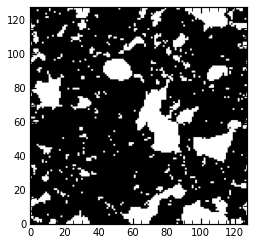

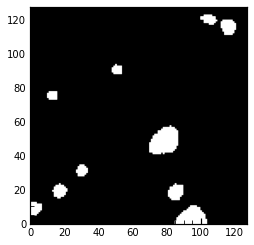

In [43]:
plt.imshow(binarized_gt_boxes_z[0][0,:,:], cmap='Greys', origin='lower')
plt.show()
plt.imshow(binarized_pred_boxes[0][0,:,:], cmap='Greys', origin='lower')

Plot the histograms of halo masses in the predicted ionized and neutral regions.

In [ ]:
plot_histogram(n_rec_halo_masses,'Predicted Neutral Regions n = '+str(len(n_rec_halo_masses)), save=False)
plot_histogram(i_rec_halo_masses,'Predicted Ionized Regions n = '+str(len(i_rec_halo_masses)), save=False)

In [ ]:
fig1,ax1 = plot_histogram(n_rec_halo_masses,
            'Predicted Neutral Regions n = '+str(len(n_rec_halo_masses)), save=False, label='Neutral Region Halos')
fig2, ax2 = plot_histogram(i_rec_halo_masses,'Comparison of Neutral and Ionized Regions', 
                           save=False, ax=ax1, fig=fig1, label='Ionized Region Halos')
ax2.set_title('Comparison of HMD in Predicted Neutral and Ionized Regions', fontsize=20);

In [ ]:
fig3,ax3 = plot_histogram(n_gt_halo_masses,
            'Predicted Neutral Regions n = '+str(len(n_gt_halo_masses)), save=False, label='Neutral Region Halos')
fig4, ax4 = plot_histogram(i_gt_halo_masses,'Comparison of Neutral and Ionized Regions', 
                           save=False, ax=ax3, fig=fig3, label='Ionized Region Halos')
ax4.set_title('Comparison of HMD in Ground Truth Neutral and Ionized Regions', fontsize=20);

Clearly, there are significant differences between the HMDs in the recovered maps vs the ground truth maps ionized and neutral regions. The most obvious difference is that the neutral and ionized region halos mass populations in the predicted maps are relatively identical (with minor differences - they nearly completely overlap), however, the halo mass populations in the neutral and ionized regions of the ground truth maps are quite different - there are roughly fewer halos at all masses in the ionized regions than in the neutral regions, except for the second grouping from the left.

To further investigate we can analyze the population of halo masses that are in the ionized regions of the ground truth maps but not in the ionized regions of the recovered maps.

In [ ]:
fig5,ax5 = plot_histogram(i_rec_halo_masses,
            'Predicted Neutral Regions n = '+str(len(n_gt_halo_masses)), save=False, label='Predicted')
fig6, ax6 = plot_histogram(i_gt_halo_masses,'Comparison of Neutral and Ionized Regions', 
                           save=False, ax=ax5, fig=fig5, label='Ground Truth')
ax6.set_title('Comparison of HMD: Predicted Ionized and Ground Truth Ionized', fontsize=20);
print('This does not tell us very much however, given each histogram is independently normalized, so you cannot say directly that one has more of these than the other.')

Look at the halo masses in the recovered ionized regions and the ground truth ionized regions, which as we know only take on a discrete set of mass values, so we can just subtract their counts to obtain the difference. We want to know what halo masses are not captured by the predicted ionized bubbles.

In [ ]:
uniq_i_gt_masses, uniq_i_gt_mass_counts = np.unique(i_gt_halo_masses, return_counts=True)
uniq_i_rec_masses, uniq_i_rec_mass_counts = np.unique(i_rec_halo_masses, return_counts=True)

# double check all masses in one are in the other
common_masses = np.intersect1d(uniq_i_gt_masses,uniq_i_rec_masses)
print('All halo masses in ground truth ionized regions are also in predicted ionized regions: ',
      ((len(common_masses)==len(uniq_i_rec_masses)) and (len(common_masses)==len(uniq_i_gt_masses)))) 

common_mass_counts =  uniq_i_gt_mass_counts - uniq_i_rec_mass_counts

In [ ]:
fig9,ax9=plt.subplots(figsize=[14,8])

fracs = common_mass_counts / uniq_i_gt_mass_counts
i_rec_missed_inds_frac = np.argwhere(fracs > 0)[:,0]
i_rec_incorr_inds_frac = np.argwhere(fracs < 0)[:,0]
i_rec_missed_fracs = np.array(fracs[i_rec_missed_inds_frac])
i_rec_missed_masses = np.array(common_masses[i_rec_missed_inds_frac])
i_rec_incorr_fracs = np.array(fracs[i_rec_incorr_inds_frac])
i_rec_incorr_masses = np.array(common_masses[i_rec_incorr_inds_frac])

ax9.bar(np.log10(i_rec_missed_masses), i_rec_missed_fracs, width=0.119,alpha=0.6,
        edgecolor='black', linewidth=1,color='blue', label='halos in GTI regions but not in PI regions')
ax9.bar(np.log10(i_rec_incorr_masses), i_rec_incorr_fracs, width=0.119,alpha=0.6,
        edgecolor='black', linewidth=1, color='red', label='halos in PI regions but not in GTI regions')
ax9.set_ylabel(r'$\frac{N_{GTI} - N_{PI}}{N_{GTI}}$', fontsize=25)
ax9.set_xlabel(r'$log(\frac{M_{Halo}}{M_{Sun}})$', fontsize=25)
ax9.tick_params(axis='x',labelsize=20)
ax9.tick_params(axis='y',labelsize=20)
ax9.legend(fontsize=15)
#fig9.savefig('/users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/102521/bar_graph_mischaracterized_halos.jpeg');

In [ ]:
# Look at halos incorrectly identified as ionized by the predicted map, and those missed by predicted map that
# are ionized in the ground truth map

i_rec_missed_inds = np.argwhere(common_mass_counts > 0)[:,0]
i_rec_incorr_inds = np.argwhere(common_mass_counts < 0)[:,0]
i_rec_missed_counts = np.array(common_mass_counts[i_rec_missed_inds])
i_rec_missed_masses = np.array(common_masses[i_rec_missed_inds])
i_rec_incorr_counts = -1*np.array(common_mass_counts[i_rec_incorr_inds])
i_rec_incorr_masses = np.array(common_masses[i_rec_incorr_inds])

# make array to call plt.hist on
n_halos = np.sum(i_rec_missed_counts)
i_rec_missed_halo_masses = np.zeros(n_halos)
start_ind = 0
for i in range(len(i_rec_missed_counts)):
    end_ind = start_ind+i_rec_missed_counts[i]
    i_rec_missed_halo_masses[start_ind:end_ind] = i_rec_missed_masses[i]
    start_ind=end_ind

n_halos2 = np.sum(i_rec_incorr_counts)
i_rec_incorr_halo_masses = np.zeros(n_halos2)
start_ind2 = 0
for j in range(len(i_rec_incorr_counts)):
    end_ind2 = start_ind2+i_rec_incorr_counts[j]
    i_rec_incorr_halo_masses[start_ind2:end_ind2] = i_rec_incorr_masses[j]
    start_ind2=end_ind2

In [ ]:
num_bins = len(common_masses)
xmin,xmax = np.log10(common_masses)[0],np.log10(common_masses)[-1] 

fig7,ax7 = plot_histogram(i_rec_missed_halo_masses, '', save=False, bins=num_bins, lims=(xmin,xmax))
ax7.set_title('HMD of halos in ionized regions of GT map but not in predicted ionized regions', fontsize=20)
ax7.set_xlim(xmin=xmin, xmax=xmax)
#fig7.savefig('/users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/102521/halos_ionized_in_GT_not_in_pred_ionizedz8.0frac.jpeg')

fig8,ax8 = plot_histogram(i_rec_incorr_halo_masses, '', save=False, bins=num_bins, lims=(xmin,xmax)) 
ax8.set_title('HMD of halos in ionized regions of predicted map but not in GT ionized regions', fontsize=20)
ax8.set_xlim(xmin=xmin, xmax=xmax);
fig8.savefig('/users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/102521/halos_ionized_in_pred_not_in_GT_ionizedz8.0.jpeg')

One interesting thing to note is the degeneracy of halo masses, which we can quantify by looking at the number of unique halo masses produced in the simulation as follows. As we see, the majority of the halos seem to be of one mass (nearly 3.85 million of the total 4.8 million halos). The unique halo masses also happen to be equally spaced in log-space.

In [ ]:
unique_loghalo_masses, unique_loghalo_mass_counts = np.unique(np.log10(halo_masses_cube), return_counts=True)
print('Unique halo masses (log base 10): ', unique_loghalo_masses, '\n', 
      'Unique halo masses counts: ',unique_loghalo_mass_counts)
fig2, ax2 = plot_histogram(i_box_halo_masses,'Ionized Regions n = '+str(len(i_box_halo_masses)))
ax2.vlines(unique_loghalo_masses, ymin=0.9*1e-3, ymax=5, linestyles='--', color='r');

We can check that our halo sorting algorithm is working properly by overplotting the designated neutral and ionized halo coordinates onto a recovered binarized slice of the coeval box. Here, we will again choose the $x=0$ slice.

In [56]:
# We need to get the halo coords with x = 0

ionized_slice = ionized_box[:,:,0]
halo_coords_slice = halos.halo_coords[halos.halo_coords[:,2]==0]
halo_masses_slice = halos.halo_masses[halos.halo_coords[:,2]==0]
nslice_halo_coords, nslice_halo_masses, islice_halo_coords, islice_halo_masses = get_n_i_mass_coords(halo_coords_slice, halo_masses_slice, ionized_slice)                                                                                                                                                                                                                                  

fig3, ax3 = plt.subplots(figsize=[14, 8])

ax3.imshow(ionized_slice, cmap='Greys')
plt.gca().invert_yaxis()
im = ax3.scatter(x=nslice_halo_coords[:,1], y=nslice_halo_coords[:,0], 
            marker='*', s=5.0, label = 'Neutral Region Halos', c='r')
im2 = ax3.scatter(x=islice_halo_coords[:,1], y=islice_halo_coords[:,0], 
            marker='*', s=5.0, label = 'Ionized Region Halos', c='blue')
ax3.set_xlim(0, 127)
ax3.set_ylim(0, 127)
ax3.legend(fontsize=14, loc='right')
ax3.set_ylabel('z-axis [Mpc]', fontsize=20)
ax3.set_xlabel('y-axis [Mpc]', fontsize=20)
ax3.set_title('Binarized Map for Slice $x = 0$', fontsize=20);
#fig3.savefig('/Users/jacobkennedy/Desktop/PHYS_459/'+'overtop_neutral_5_slices_deep'+'.jpeg')

NameError: name 'ionized_box' is not defined

Clearly, the sorting algorithm is working correctly, as the ionized region halos appear in the white bubbles, and the neutral halos in the black space.

In [ ]:
# power law fit to histogram
from scipy.optimize import curve_fit

def power_law(x, A, alpha):
    return A*x**alpha

log_halo_masses = np.log10(i_halo_masses_box)
data_entries, bins = np.histogram(log_halo_masses, bins=10, density=True)

binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(power_law, xdata=binscenters, ydata=data_entries)# p0=[2, -0.001])
print(popt)
xspace = np.linspace(min(log_halo_masses),max(log_halo_masses), 1000)

# Plot the histogram and the fitted function.
plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
plt.plot(xspace, power_law(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.plot(xspace,  power_law(xspace, *popt)-power_law(xspace, 3.97032615e+09, -9.87071191), color='red', linewidth=2.5, label=r'Fitted function')

In [ ]:
# Now look at all halos in a rectangular prism 5 voxels deep, sum up mass in this prism

n_slice_halo_inds = np.argwhere(n_halo_coords_box[:,2] < 5)
i_slice_halo_inds = np.argwhere(i_halo_coords_box[:,2] < 5)
n_slice_halo_masses = n_halo_masses_box[n_slice_halo_inds][:,0]
i_slice_halo_masses = i_halo_masses_box[i_slice_halo_inds][:,0]
n_slice_halo_coords = n_halo_coords_box[n_slice_halo_inds][:,0]
i_slice_halo_coords = i_halo_coords_box[i_slice_halo_inds][:,0]

In [ ]:
# get total mass in a voxel prism 5 slices deep

n_masses_grid = np.zeros((128,128))
for i in range(len(n_slice_halo_coords)):
    n_z_coord, n_y_coord = n_slice_halo_coords[i][1], n_slice_halo_coords[i][0]
    n_masses_grid[n_z_coord, n_y_coord] += n_slice_halo_masses[i]
i_masses_grid = np.zeros((128,128))
for i in range(len(i_slice_halo_coords)):
    i_z_coord, i_y_coord = i_slice_halo_coords[i][1], i_slice_halo_coords[i][0]
    i_masses_grid[i_z_coord, i_y_coord] += i_slice_halo_masses[i]

In [ ]:
fig, ax = plt.subplots(figsize=[14, 8])


slice_binarized_pred = binarized_pred[:,:,0]
ax.imshow(slice_binarized_pred, cmap='Greys')
im = ax.imshow(np.log10(n_masses_grid.T), cmap='coolwarm')
#ax.imshow(i_masses_grid, cmap='jet') #,  interpolation='nearest')
#plt.gca().invert_yaxis()
#im = ax.scatter(x=n_slice_halo_coords[:,1], y=n_slice_halo_coords[:,0], 
#            marker='*', s=5.0, label = 'Neutral Region Halos', c=np.log10(n_slice_halo_masses), cmap='jet')
#im2 = ax.scatter(x=i_slice_halo_coords[:,1], y=i_slice_halo_coords[:,0], 
#            marker='*', s=5.0, label = 'Ionized Region Halos', c=np.log10(i_slice_halo_masses), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127)
ax.set_ylim(0, 127)
#ax[i].legend(fontsize=12, loc='right')
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
ax.set_title('Total Mass (5 slices deep)', fontsize=20)
fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/'+'overtop_neutral_5_slices_deep'+'.jpeg')

In [ ]:
# For a constant background, we plot the first slice of binarized bubbles

if 0:
    num_slice = 10
    fig, ax = plt.subplots(nrows=10, ncols=1, figsize=[30, 80])
if 1:
    num_slice = 5
    #fig, ax = plt.subplots(figsize=[14, 8])

for i in range(num_slice):
    fig, ax = plt.subplots(figsize=[14, 8])
    # Now get the halo masses and coords corresponding to a slice along axis=0, slice_index = 0
    n_halo_coords_box = halo_coords_low_res[neutral_halo_inds]
    i_halo_coords_box = halo_coords_low_res[ionized_halo_inds]
    n_halo_masses_box = sorted_halo_masses[neutral_halo_inds]
    i_halo_masses_box = sorted_halo_masses[ionized_halo_inds]

    n_slice_halo_inds = np.argwhere(n_halo_coords_box[:,2] < i+1).flatten() # will progressively show more
    i_slice_halo_inds = np.argwhere(i_halo_coords_box[:,2] < i+1).flatten()
    n_slice_halo_masses = n_halo_masses_box[n_slice_halo_inds]
    i_slice_halo_masses = i_halo_masses_box[i_slice_halo_inds]
    n_slice_halo_coords = n_halo_coords_box[n_slice_halo_inds]
    i_slice_halo_coords = i_halo_coords_box[i_slice_halo_inds]
    
    #if we just want to see where the large halos are
    
    n_slice_log_halo_masses = np.log10(n_slice_halo_masses)
    i_slice_log_halo_masses = np.log10(i_slice_halo_masses)
    n_slice_large_log_halo_inds = np.argwhere(n_slice_log_halo_masses>=12.0).flatten()
    i_slice_large_log_halo_inds = np.argwhere(i_slice_log_halo_masses>=12.0).flatten()
    n_slice_large_log_halo_masses = n_slice_log_halo_masses[n_slice_large_log_halo_inds]
    i_slice_large_log_halo_masses = i_slice_log_halo_masses[i_slice_large_log_halo_inds]
    n_slice_large_halo_coords = n_slice_halo_coords[n_slice_large_log_halo_inds]
    i_slice_large_halo_coords = i_slice_halo_coords[i_slice_large_log_halo_inds]
    
    # Now plot to make sure the halos have been assigned to the proper region visually

    slice_binarized_pred = binarized_pred[:,:,0] 
    ax.imshow(slice_binarized_pred, cmap='Greys')#,  interpolation='nearest')
    plt.gca().invert_yaxis()
    im = ax.scatter(x=n_slice_halo_coords[:,1], y=n_slice_halo_coords[:,0], 
               marker='*', s=5.0, label = 'Neutral Region Halos', c=np.log10(n_slice_halo_masses), cmap='jet')
    im2 = ax.scatter(x=i_slice_halo_coords[:,1], y=i_slice_halo_coords[:,0], 
               marker='*', s=5.0, label = 'Ionized Region Halos', c=np.log10(i_slice_halo_masses), cmap='jet')
    fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax).set_label(label='log($M_{halo}/M_{Sun}$)',size=20)

    ax.set_xlim(0, 127)
    ax.set_ylim(0, 127)
    #ax[i].legend(fontsize=12, loc='right')
    ax.set_ylabel('z-axis [Mpc]', fontsize=20)
    ax.set_xlabel('y-axis [Mpc]', fontsize=20)
    filename = 'fixed_foreground_with_numslice_galaxies' + str(i)
    fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/'+filename+'.jpeg')

In [ ]:
np.unique(n_slice_large_log_halo_masses)

In [ ]:
n_uniq_masses, n_uniq_mass_counts = np.unique(n_halo_masses_box, return_counts=True)
i_uniq_masses, i_uniq_mass_counts = np.unique(i_halo_masses_box, return_counts=True)
n_masses_12_counts = np.sum(n_uniq_mass_counts[-1:])
i_masses_12_counts = np.sum(i_uniq_mass_counts[-1:])
n_masses_12_frac = n_masses_12_counts / len(n_halo_masses_box)
i_masses_12_frac = i_masses_12_counts / len(i_halo_masses_box)

print('Percentage of largest halo masses in neutral regions: ' + repr(n_masses_12_frac*100))
print('Percentage of largest halo masses in ionized regions: ' + repr(i_masses_12_frac*100))

In [ ]:
# Convert halo_coords_slice into distance coords to plot overtop of bubble plot

def vox_to_dist(box_len, HII_dim, vox_coords):
    dim = HII_dim*3
    dist_coords = (box_len/dim)*vox_coords
    return dist_coords

dist_halo_coords_slice = vox_to_dist(BOX_LEN, HII_DIM, halo_coords_slice[:, :2])

# Note: Indexing of the coeval boxes is [z,y,x], and hence a slice-axis=-1 $\implies$ along z (slice of x-y plane), slice-axis=0 $\implies$ along x (slice of z-y plane), slice-axis=+1 $\implies$ along y (slice of z-x plane).

In [ ]:
orig_coeval_box = Y[0]
orig_coeval_box_slice = orig_coeval_box[:,:,0]
#fig, ax = plt.subplots(figsize=[14, 8])
plt.imshow(orig_coeval_box_slice, cmap='coolwarm')#,  interpolation='nearest')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

Ionized bubbles are those with zero 21cm signal, so $\Delta T = 0$, hence these areas will appear white in binarized boxes, whilst neutral areas will be black (presence of 21cm signal). Ypred contains the normalized predicted data not yet binarized. Therefore, we will adopt the cutoff used in Gagnon-Hartman et al. 2021 of 0.9, to classify a box as ionized or neutral. Therefore, any voxel with a value $\geq 0.9$ will be mapped to 1.0, and hence be considered neutral. Conversely, any voxel $<0.9$ will be mapped to 0, and hence be classified as fully ionized.

In [ ]:
# Plot the binarized data after applying 0.9 cutoff, do so for tranverse slice at z=0

cutoff = 0.9
y_0 = Ypred[0]
slice_binarized_pred = y_0[:,:,0] # z = 0
super_threshold_indices = (slice_binarized_pred >= cutoff) # map to 1
sub_threshold_indices = (slice_binarized_pred < cutoff) # map to 0
slice_binarized_pred[super_threshold_indices] = 1 # 
slice_binarized_pred[sub_threshold_indices] = 0

In [ ]:
fig, ax = plt.subplots(figsize=[14, 8])
ax.imshow(slice_binarized_pred, cmap='Greys')#,  interpolation='nearest')
# for x=x_coord, y=y_coord, c=mass, and cmap will put gradient of masses
plt.gca().invert_yaxis()
im = ax.scatter(x=dist_halo_coords_slice[:,0], y=dist_halo_coords_slice[:,1], 
           marker='*', s=5.0, c=np.log10(halo_masses_slice), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127.6666666)
ax.set_ylim(0, 127.6666666)
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
#plt.show()
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/color_coded_masses_over_bubbles.jpeg')

In [ ]:
i_halo_coords_box[:,1]//3

In [ ]:


fig, ax = plt.subplots(figsize=[14, 8])
ax.imshow(orig_coeval_box_slice, cmap='Greys')#,  interpolation='nearest')
# for x=x_coord, y=y_coord, c=mass, and cmap will put gradient of masses
plt.gca().invert_yaxis()
im = ax.scatter(x=dist_halo_coords_slice[:,0], y=dist_halo_coords_slice[:,1], 
           marker='*', s=5.0, c=np.log10(halo_masses_slice), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127.6666666)
ax.set_ylim(0, 127.6666666)
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/color_coded_masses_over_bubbles2.jpeg')

In [ ]:
print(slice_binarized_pred)

In [ ]:
a = np.array([0.01, 0.9, 0.91, 0.5, 0.001])
super_threshold_indices = (a >= 0.9)
sub_threshold_indices = (a < 0.9)
a[super_threshold_indices] = 1
a[sub_threshold_indices] = 0

In [ ]:
print(a)